In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os

from dotenv import load_dotenv
load_dotenv()

# Variables:
PROJECT_ID=os.getenv('PROJECT_ID')
BUCKET_NAME=os.getenv('BUCKET_NAME')
USER=os.getenv('USER')
LOCATION=os.getenv('LOCATION')
SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')

## Homework

### Dataset

In this homework, we will use the California Housing Prices from [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices). The goal of this homework is to create a regression model for predicting housing prices (column `'median_house_value'`).

In [ ]:
data_gcs_uri = f"gs://{BUCKET_NAME}/00_intro/housing.csv"

In [ ]:
# Imports
import kfp
from kfp.dsl import (
    Input,
    Output, 
    Dataset,
    component,
    Model,
    Artifact,
    ClassificationMetrics,
)

artifacts_uri = '../../artifacts/homework/05_trees/'
if not os.path.exists(artifacts_uri):
    os.makedirs(artifacts_uri)

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import joblib

from sklearn.tree import export_text

### Preparing the dataset 

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2.
But in contrast to homework #2, we are going to use all columns of the dataset.

First, keep only the records where `ocean_proximity` is either `'<1H OCEAN'` or `'INLAND'`

Preparation:

* Fill missing values with zeros.
* Apply the log transform to `median_house_value`.
* Do train/validation/test split with 60%/20%/20% distribution. 

In [ ]:
# Components
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install=[
        "gcp_python_client_functions",
    ],
)
def read_data_gcs(
    project_id: str, 
    data_gcs_uri: str,
    out_df: Output[Dataset], 
):
    import pandas as pd
    import numpy as np
    import pickle
    
    from gcp_python_client_functions.clients import Storage
    ##################### CODE:
    stg_obj = Storage(project_id)

    df = pd.read_csv(data_gcs_uri)

    # Base formatting:
    df.columns = df.columns.str.lower()
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for c in categorical_columns:
        df[c] = df[c].str.lower()

    # Subset:
    df = df[
        (df.ocean_proximity == '<1h ocean') |  (df.ocean_proximity == 'inland')
    ]
    df.ocean_proximity = df.ocean_proximity=='<1h ocean'

    # 1. Fill missing values with zeros
    df.total_bedrooms = df.total_bedrooms.fillna(value = 0)
    # 2. Apply the log transform to `median_house_value`
    df['log_median_house_value'] = np.log(df.median_house_value)
    df = df.drop(['median_house_value'], axis=1)

    pd.to_pickle(df, out_df.uri + ".pkl")

read_data_gcs_func = read_data_gcs.python_func

In [ ]:
art_df = Dataset(uri = artifacts_uri +'df')

read_data_gcs_func(
    project_id = PROJECT_ID, 
    data_gcs_uri = data_gcs_uri,
    out_df = art_df,
)

df = pd.read_pickle(art_df.uri+'.pkl')

In [ ]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,log_median_house_value
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,True,12.973863
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,True,12.287653
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,True,12.419570
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,True,12.554967
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,True,12.287192


* Use the `train_test_split` function and set the `random_state` parameter to 1.

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def split_data(
    in_df: Input[Dataset],
    out_df_train: Output[Dataset], 
    out_df_test: Output[Dataset],
    test_size: float = 0.2,
    random_state: int = 1,
):
    import pandas as pd
    from sklearn.model_selection import train_test_split

    df = pd.read_pickle(in_df.uri + ".pkl") 
    
    df_train, df_test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
    )

    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    pd.to_pickle(df_train, out_df_train.uri + ".pkl")
    pd.to_pickle(df_test, out_df_test.uri + ".pkl")

split_data_func = split_data.python_func

In [ ]:
art_df_train_full = Dataset(uri = artifacts_uri +'df_train_full')
art_df_train = Dataset(uri = artifacts_uri +'df_train')
art_df_test = Dataset(uri = artifacts_uri +'df_test')
art_df_val = Dataset(uri = artifacts_uri +'df_val')

split_data_func(
    in_df = art_df,
    out_df_train = art_df_train_full, 
    out_df_test = art_df_test,
    test_size = 0.2,
    random_state = 1,
)
split_data_func(
    in_df = art_df_train_full,
    out_df_train = art_df_train, 
    out_df_test = art_df_val,
    test_size = 0.25,
    random_state = 1,
)

In [ ]:
df_val = pd.read_pickle(art_df_val.uri+'.pkl')
df_val.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,log_median_house_value
0,-122.74,38.48,12.0,4174.0,670.0,1882.0,647.0,4.5510,True,12.091223
1,-121.67,36.93,22.0,569.0,132.0,542.0,125.0,2.1875,True,12.141534
2,-120.90,39.95,20.0,1349.0,238.0,601.0,203.0,3.5417,False,11.478334
3,-118.14,34.02,44.0,1715.0,460.0,1740.0,423.0,2.7019,True,11.940152
4,-118.11,33.80,36.0,1837.0,319.0,810.0,305.0,4.3897,True,12.367341


## Question 1

Let's train a decision tree regressor to predict the `median_house_value` variable. 

* Train a model with `max_depth=1`.

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def tree_prep_train(
    in_df_train: Input[Dataset],
    label: str,
    out_dt: Output[Model],
    max_depth: int = None,
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    from sklearn.tree import DecisionTreeRegressor

    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 

    y_train = df_train[label].copy()
    x_train = df_train.drop([label], axis=1)
    features = x_train.columns.to_list()

    dt = DecisionTreeRegressor(
        max_depth = max_depth, 
    )
    
    dt.fit(x_train, y_train)

    with open(out_dt.uri+'.joblib', 'wb') as f:
        pickle.dump(dt, f)

    return features

tree_prep_train_func = tree_prep_train.python_func

In [ ]:
art_dt = Model(uri = artifacts_uri +'dt')

features = tree_prep_train_func(
    in_df_train = art_df_train,
    label = 'log_median_house_value',
    out_dt = art_dt,
    max_depth = 1,
)

Which feature is used for splitting the data?

* `ocean_proximity`✅
* `total_rooms`
* `latitude`
* `population`

In [ ]:
dt = joblib.load(art_dt.uri + '.joblib')

print(export_text(dt, feature_names=features))

|--- ocean_proximity <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity >  0.50
|   |--- value: [12.30]



## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def rf_prep_train(
    in_df_train: Input[Dataset],
    label: str,
    out_rf: Output[Model],
    max_depth: int = None,
    n_estimators: int = 100,
    random_state: int = 1, 
    n_jobs: int=-1,
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    from sklearn.ensemble import RandomForestRegressor

    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 

    y_train = df_train[label].copy()
    x_train = df_train.drop([label], axis=1)
    features = x_train.columns.to_list()

    rf = RandomForestRegressor(
        max_depth = max_depth, 
        n_estimators = n_estimators,
        random_state = random_state,
        n_jobs = n_jobs,
    )
    
    rf.fit(x_train, y_train)

    with open(out_rf.uri+'.joblib', 'wb') as f:
        pickle.dump(rf, f)

    return features

rf_prep_train_func = rf_prep_train.python_func

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def evaluate(
    in_df_test: Input[Dataset], 
    label: str,
    in_model: Input[Model], 
) -> float:

    import pandas as pd
    import joblib
    from sklearn.metrics import mean_squared_error

    df_test = pd.read_pickle(in_df_test.uri + ".pkl") 
    model = joblib.load(in_model.uri + '.joblib')
    
    # Make prediction:
    y_test = df_test[label].copy()
    x_test = df_test.drop([label], axis=1)

    y_pred = model.predict(x_test)
    
    # Evaluate:
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    return rmse, y_pred

evaluate_func = evaluate.python_func

What's the RMSE of this model on validation?

* 0.045
* 0.245 ✅
* 0.545
* 0.845

In [ ]:
art_rf = Model(uri = artifacts_uri +'rf')

features = rf_prep_train_func(
    in_df_train = art_df_train,
    label = 'log_median_house_value',
    out_rf = art_rf,
    n_estimators = 10,
)
rmse_rf, y_pred = evaluate_func(
    in_df_test = art_df_val, 
    label = 'log_median_house_value',
    in_model = art_rf, 
)
rmse_rf

0.24435094117718684

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.

In [ ]:
def rf_train_eval(n):
    features = rf_prep_train_func(
        in_df_train = art_df_train,
        label = 'log_median_house_value',
        out_rf = art_rf,
        n_estimators = n,
    )
    rmse, _ = evaluate_func(
        in_df_test = art_df_val, 
        label = 'log_median_house_value',
        in_model = art_rf, 
    )
    return rmse

In [ ]:
scores = []

for n in range(10,201,10):
    rmse = rf_train_eval(n)
    scores.append((n,round(rmse,3)))

columns = ['n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns = columns)

[<matplotlib.lines.Line2D>]

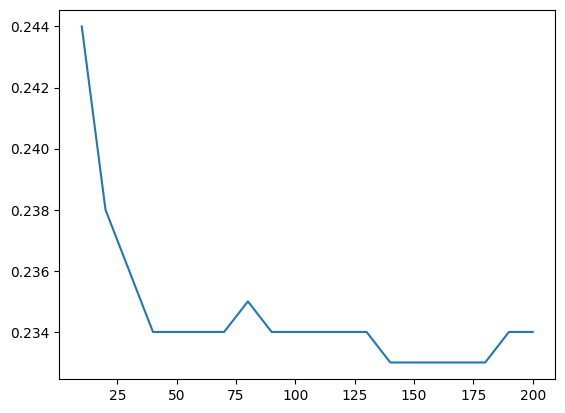

In [ ]:
plt.plot(df_scores.n_estimators, df_scores.rmse)

After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for retrieving the answer.

- 10
- 25
- 50 ✅
- 160 

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`

In [ ]:
def rf_train_eval(d,n):
    features = rf_prep_train_func(
        in_df_train = art_df_train,
        label = 'log_median_house_value',
        out_rf = art_rf,
        n_estimators = n,
        max_depth = d,
    )
    rmse, _ = evaluate_func(
        in_df_test = art_df_val, 
        label = 'log_median_house_value',
        in_model = art_rf, 
    )
    return rmse

In [ ]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10,201,10):
        rmse = rf_train_eval(d=d,n=n)
        scores.append((d,n,rmse))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores_rf = pd.DataFrame(scores, columns = columns)

<matplotlib.legend.Legend>

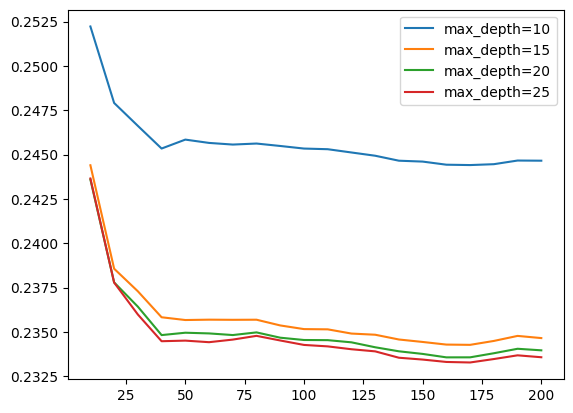

In [ ]:
for d in [10, 15, 20, 25]:
    df_subset = df_scores_rf[df_scores_rf.max_depth==d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f"max_depth={d}")

plt.legend()

In [ ]:
df_scores_rf[['max_depth','rmse']].groupby('max_depth').mean().sort_values(by = 'rmse')

,rmse
max_depth,
25,0.234769
20,0.235062
15,0.235787
10,0.245642


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25 ✅

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)

In [ ]:
features = rf_prep_train_func(
    in_df_train = art_df_train,
    label = 'log_median_house_value',
    out_rf = art_rf,
    n_estimators = 10,
    max_depth=20,
)

* Get the feature importance information from this model

In [ ]:
rf = joblib.load(art_rf.uri + '.joblib')

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in  rf.estimators_], axis=0)

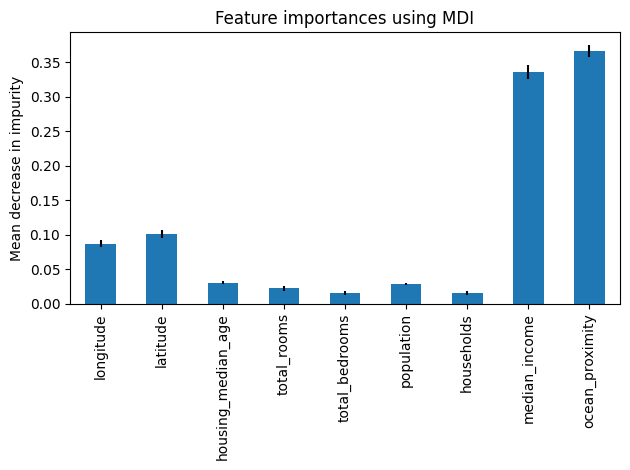

In [ ]:
forest_importances = pd.Series(importances, index=features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

What's the most important feature (among these 4)? 

* `total_rooms`
* `median_income`✅
* `total_bedrooms`
* `longitude`

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

In [ ]:
@component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = [
        "scikit-learn==1.3.1",
        "xgboost==2.0.0",
    ],
)
def xgb_train(
    in_df_train: Input[Dataset],
    in_df_val: Input[Dataset],
    
    label: str,
    
    out_xgb_model: Output[Model],
    
    eta: float = 0.3,    
    max_depth: int = 6,
    min_child_weight: int = 1,

    objective: str = 'reg:squarederror',
    eval_metric: str = 'rmse',
    
    n_jobs: int = 8,
    seed: int = 1, 
    verbosity: int = 1, # 0 (silent) - 3 (debug).

    early_stopping_rounds: int = 100,
    verbose_early: bool = False,
):
    import pandas as pd 
    import numpy as np

    import joblib
    import pickle

    import xgboost as xgb

    df_train = pd.read_pickle(in_df_train.uri + ".pkl") 
    df_val = pd.read_pickle(in_df_val.uri + ".pkl")

    y_train = df_train[label].copy()
    y_val = df_val[label].copy()

    x_train = df_train.drop([label], axis=1)
    x_val = df_val.drop([label], axis=1)
    
    features = x_train.columns.to_list()

    xgb_model = xgb.XGBRegressor(
        eta = eta,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        
        objective = objective,
        eval_metric = eval_metric,
        
        n_jobs = n_jobs,
        seed = seed,
        verbosity = verbosity,
    )
    
    xgb_model.fit(
        x_train, 
        y_train,
        early_stopping_rounds=early_stopping_rounds, 
        eval_set=[(x_train, y_train),(x_val, y_val)],
        verbose=verbose_early,
    )

    eval_results = xgb_model.evals_result()

    with open(out_xgb_model.uri+'.joblib', 'wb') as f:
        pickle.dump(xgb_model, f)

    return features, eval_results

xgb_train_func = xgb_train.python_func

In [ ]:
art_xgb_model = Model(uri = artifacts_uri +'xgb_model')

features, eval_results_03 = xgb_train_func(
    in_df_train = art_df_train,
    in_df_val = art_df_val,

    label = 'log_median_house_value',

    out_xgb_model = art_xgb_model,
)
_, eval_results_01 = xgb_train_func(
    in_df_train = art_df_train,
    in_df_val = art_df_val,

    eta = 0.1,
    
    label = 'log_median_house_value',

    out_xgb_model = art_xgb_model,
)

In [ ]:
val_rmse_03 = list(eval_results_03['validation_1'].values())[0]
val_rmse_01 = list(eval_results_01['validation_1'].values())[0]
num_iter = range(len(val_rmse_03))

<matplotlib.legend.Legend>

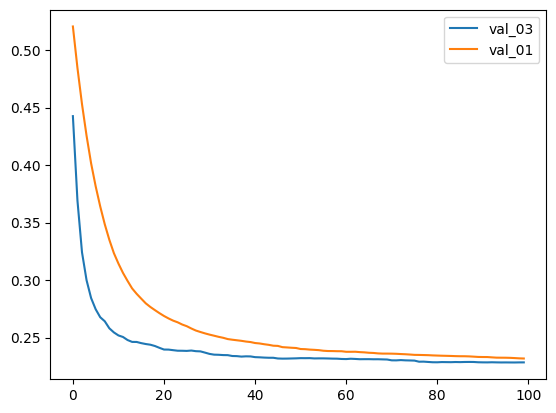

In [ ]:
plt.plot(num_iter, val_rmse_03, label='val_03')
plt.plot(num_iter, val_rmse_01, label='val_01')
plt.legend()

In [ ]:
val_rmse_01[-1]

0.23179766547455963

In [ ]:
val_rmse_03[-1]

0.22842102378368334

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value